# Create regions of interest masking with ERDDAP griddap

For this demostration notebook, we will be extracting analysed SST data from the Level 4 operational dataset created by the UK Met Office.  This dataset is published and available in the main ERDDAP Server https://coastwatch.pfeg.noaa.gov/erddap .

The plan its to create masks of regions of interest, request a data subset from the ERDDAP server, and apply the masks to make analysis on each region individually.

This justs sets the basics for a deeper or more data intensive workflow.

For this demo, we will be using the following libraries:

- [erddap-python](https://github.com/hmedrano/erddap-python) (Python client for the ERDDAP Restful API)
- [regionmask](https://regionmask.readthedocs.io/en/stable/index.html) (Creates masks of geographical regions)
- [cmocean](https://matplotlib.org/cmocean) (This library contains colormaps for commonly-used oceanographic variables)
- pandas, cartopy, matplotlib (More generally known)


*Demo by Favio Medrano*


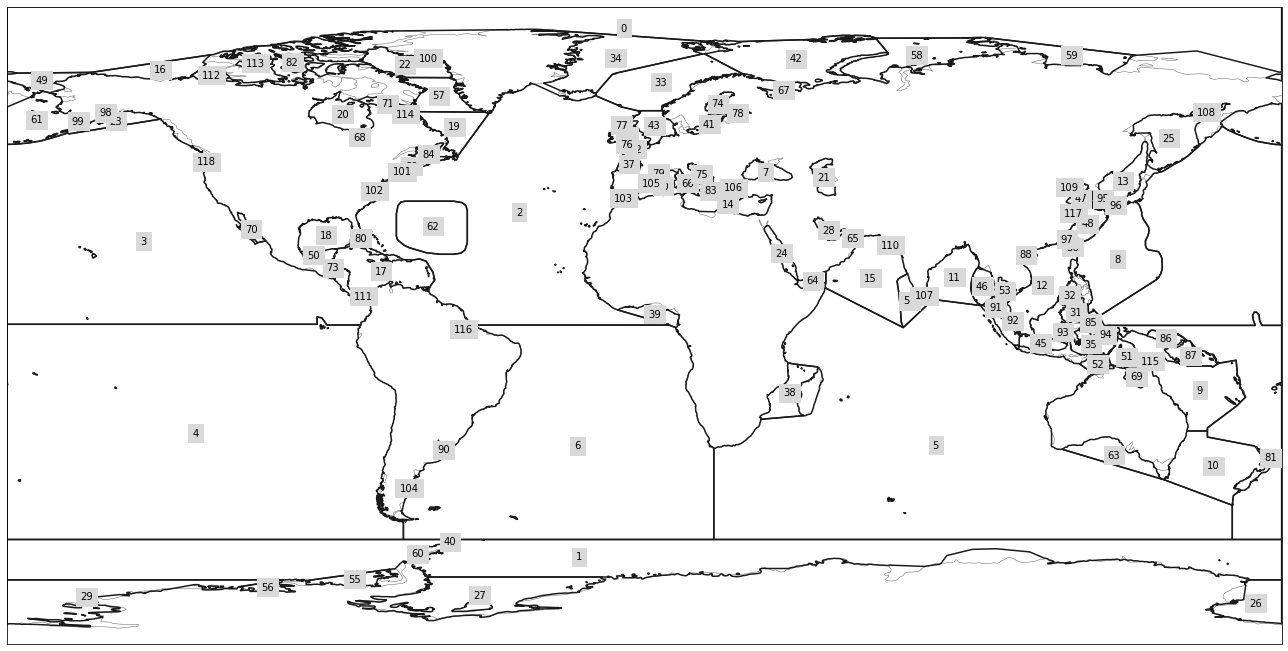

In [72]:
import matplotlib
import matplotlib.pyplot as plt

import cmocean 
import cartopy.crs as ccrs
import regionmask
import pandas as pd

# Defaults for plots
matplotlib.rcParams['figure.figsize'] = (18, 10)

# We will be using the preloaded basins regions, available in the regionmask libray.
# regionmask library can even load shapefiles to create custom regions

basins = regionmask.defined_regions.natural_earth.ocean_basins_50
basins.plot(add_label=True);
plt.tight_layout()

## The regions of interest

- Gulf of Mexico
- Bahía de Campeche
- Gulf of Honduras
- Caribbean Sea

<GeoAxesSubplot:>

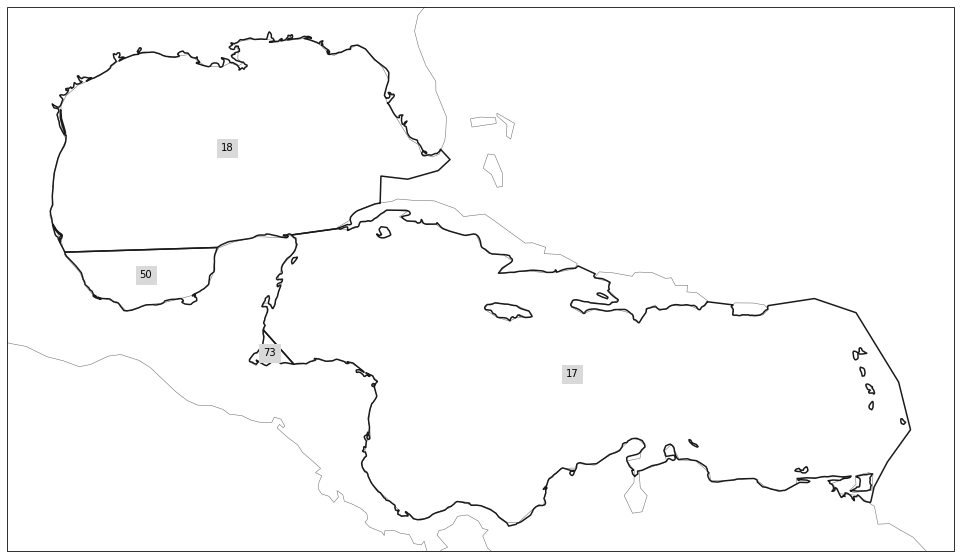

In [3]:
# This regions are mapped in the indexes 18, 50, 73 and 17 respectively
basins.plot(regions=['Gulf of Mexico','Bahía de Campeche','Gulf of Honduras','Caribbean Sea'])


## Create my region

Using this four regions already available in basins, extract they coords and create my own region


In [4]:
roi = regionmask.Regions([basins.regions[18].coords,
                          basins.regions[50].coords,
                          basins.regions[73].coords,
                          basins.regions[17].coords],
                         names=['Gulf of Mexico','Bahía de Campeche','Gulf of Honduras','Caribbean Sea'],
                         abbrevs=['GOM','BDC','GOH','MDC'],
                         name='MyROI')
roi

<regionmask.Regions>
Name:     MyROI

Regions:
0 GOM    Gulf of Mexico
1 BDC Bahía de Campeche
2 GOH  Gulf of Honduras
3 MDC     Caribbean Sea

[4 regions]

In [6]:
# The global bounds of this region in the form:
# [lonmin, latmin, lonmax, latmax]
# We will be using this global bounds to create the subset request from the ERDDAP Global SST griddap Dataset
roi.bounds_global

[-97.85758724647562, 8.493693752471486, -59.20886105003194, 30.694354152950908]

## Extract the polygon of data from L4 OSTIA Dataset Analysed SST

### Data requested from ERDDAP Griddap Dataset using erddap-python

To this we use [erddap-python](https://github.com/hmedrano/erddap-python) indexing functions, that can create DataFrames or xArray.DataArray objects fully described

In [7]:
from erddapClient import ERDDAP_Griddap

remote = ERDDAP_Griddap('https://coastwatch.pfeg.noaa.gov/erddap','jplUKMO_OSTIAv20')

# Show me the dataset general information
print(remote)

<erddapClient.ERDDAP_Griddap>
Title:       Global SST & Sea Ice Analysis, L4 OSTIA, UK Met Office, Global, 0.05°, Daily, 2007-present
Server URL:  https://coastwatch.pfeg.noaa.gov/erddap
Dataset ID:  jplUKMO_OSTIAv20
Dimensions: 
  time (double) range=(cftime.DatetimeGregorian(2007, 1, 1, 12, 0, 0, 0), cftime.DatetimeGregorian(2021, 5, 20, 12, 0, 0, 0)) 
    Standard name: time 
    Units:         seconds since 1970-01-01T00:00:00Z 
  latitude (float) range=(-89.975, 89.975) 
    Standard name: latitude 
    Units:         degrees_north 
  longitude (float) range=(-179.975, 179.975) 
    Standard name: longitude 
    Units:         degrees_east 
Variables: 
  analysed_sst (float) 
    Standard name: sea_surface_foundation_temperature 
    Units:         degree_C 
  analysis_error (float) 
    Standard name: sea_surface_temperature_error 
    Units:         degree_C 
  sea_ice_fraction (float) 
    Standard name: sea_ice_area_fraction 
    Units:         1 
  mask (byte) 
    Standard n

### erddap-python usage

The below command will create a query constrainst to extract a subset of the 
griddap dataset.
The last chain of methods will return a xarray DataArray with only the data and 
dimensions subset

The constraints are, time="2021-05-20" , and get the global bounds of our region 
of interest

> For more examples on usage of erddap-python please refer to notebooks 
folder in the https://github.com/hmedrano/erddap-python repository

In [8]:


daSubset = ( remote.setResultVariables('analysed_sst') 
                   .setSubset(time="2021-05-20",
                              latitude=slice(roi.bounds_global[1], roi.bounds_global[3]),
                              longitude=slice(roi.bounds_global[0], roi.bounds_global[2]))
                   .getxArray()
           )
daSubset

<xarray.Dataset>
Dimensions:       (latitude: 445, longitude: 774, time: 1)
Coordinates:
  * time          (time) object 2021-05-20 12:00:00
  * latitude      (latitude) float64 8.475 8.525 8.575 ... 30.57 30.62 30.68
  * longitude     (longitude) float64 -97.88 -97.83 -97.78 ... -59.27 -59.23
Data variables:
    analysed_sst  (time, latitude, longitude) float32 ...
Attributes: (12/50)
    acknowledgement:            Please acknowledge the use of these data with...
    cdm_data_type:              Grid
    comment:                    WARNING Some applications are unable to prope...
    Conventions:                CF-1.6, COARDS, ACDD-1.3
    creator_email:              servicedesk@myocean.eu.org
    creator_name:               UKMO as part of MyOcean
    ...                         ...
    summary:                    A Group for High Resolution Sea Surface Tempe...
    testOutOfDate:              now-2days
    time_coverage_end:          2021-05-20T12:00:00Z
    time_coverage_start:        2007-01-01T12:00:00Z
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, UK M...
    Westernmost_Easting:        -179.975

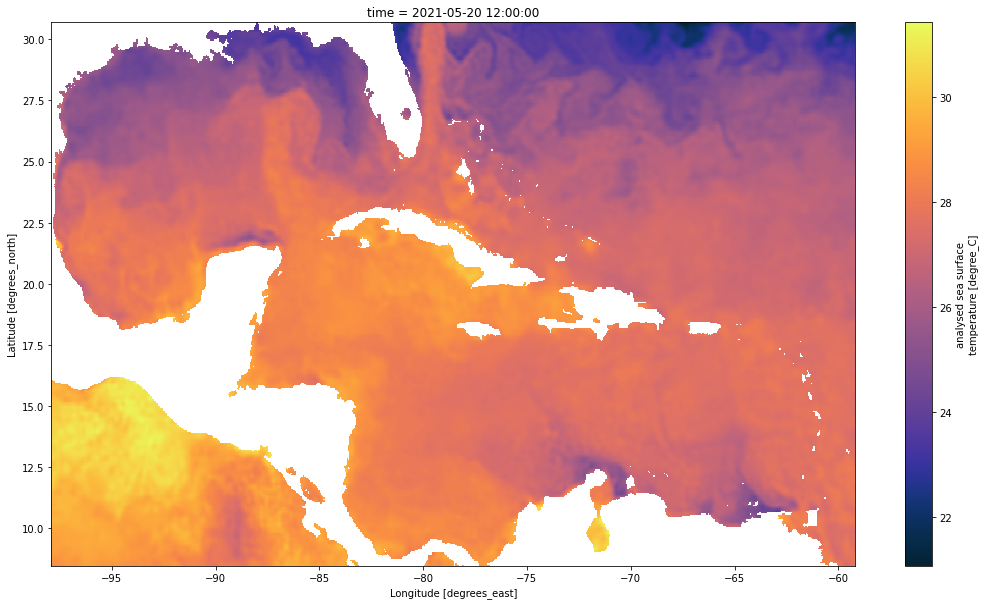

In [9]:
# Plot the requested data
daSubset['analysed_sst'].plot(cmap=cmocean.cm.thermal)

## Create mask's for each of the regions of interest

Using the regionmask "roi". With the same grid of the above ERDDAP request

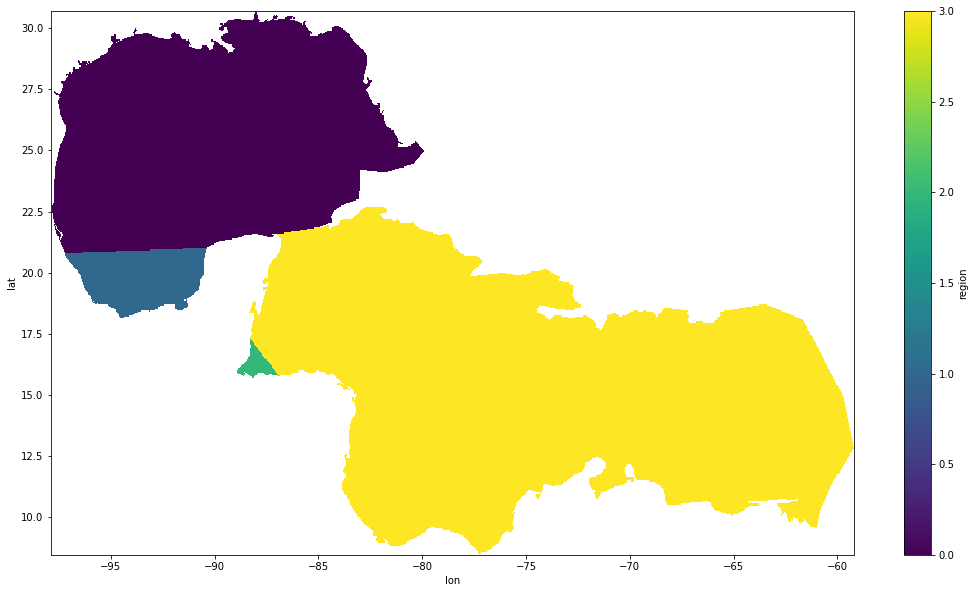

In [13]:
# Mask for the grid of the daSubset DataArray
maskRoi = roi.mask(daSubset.coords['longitude'], daSubset.coords['latitude'])
maskRoi.plot()

In [27]:
# Mask values for each Region
rsst = {
    'GOM' : daSubset.where(maskRoi.values == 0),
    'BDC' : daSubset.where(maskRoi.values == 1),
    'GOH' : daSubset.where(maskRoi.values == 2),
    'MDC' : daSubset.where(maskRoi.values == 3),    
}

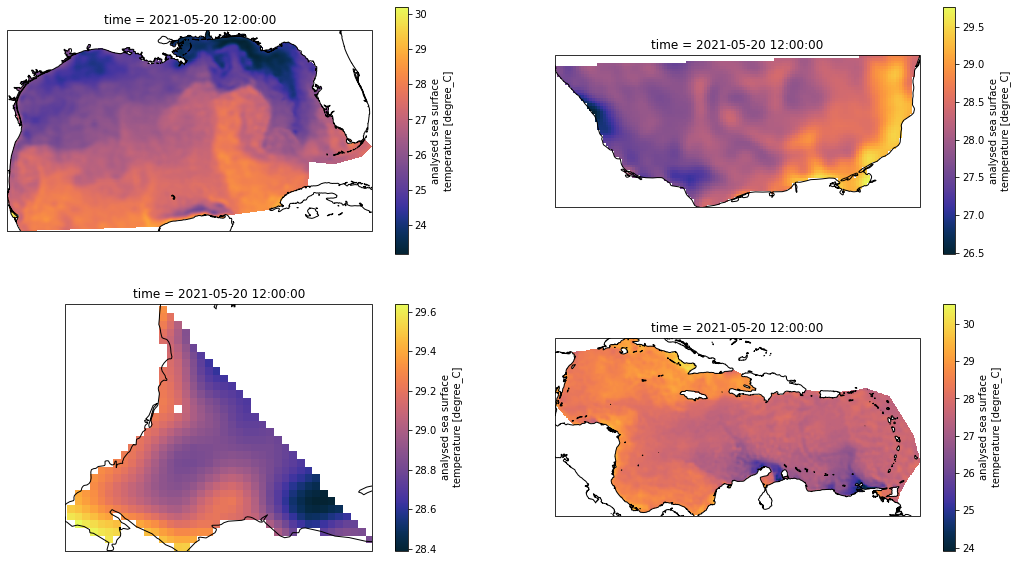

In [29]:
# Plot all masked regions

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, subplot_kw=dict(projection=ccrs.PlateCarree()))

for region, sax in zip(['GOM','BDC','GOH','MDC'], [ax1,ax2,ax3,ax4]):
    
    rsst[region]['analysed_sst'].plot(xlim=[roi[region].bounds[0], roi[region].bounds[2]],
                                      ylim=[roi[region].bounds[1], roi[region].bounds[3]],
                                      ax=sax, cmap=cmocean.cm.thermal)
    sax.coastlines()



<AxesSubplot:title={'center':'Regions of interested 2021-05-20 Basic Statistics'}>

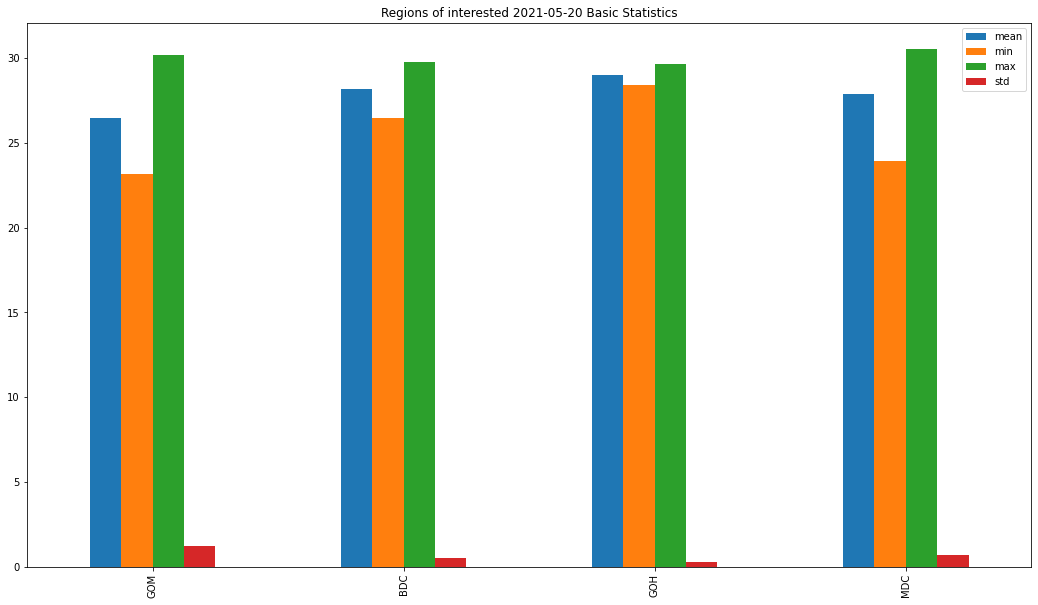

In [70]:
dfData = [ [rsst[region]['analysed_sst'].mean().values.flatten()[0],
            rsst[region]['analysed_sst'].min().values.flatten()[0],
            rsst[region]['analysed_sst'].max().values.flatten()[0],
            rsst[region]['analysed_sst'].std().values.flatten()[0],
            ] for region in ['GOM','BDC','GOH','MDC']  ]

statsdf = pd.DataFrame(columns=['mean', 'min', 'max', 'std'],
                       data=dfData,
                       index=['GOM','BDC','GOH','MDC'])

statsdf.plot.bar(title='Regions of interested 2021-05-20 Basic Statistics')